# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [1]:
# Подключение Google Drive к Colab
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

# Настройка структуры папок проекта
PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'

print('Проектная папка подключена:', PROJECT_DIR)

Mounted at /content/drive
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [2]:
# Импорт библиотек для обработки и анализа данных
import numpy as np
import pandas as pd

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения pandas и matplotlib
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('ggplot')

# Проверка версий библиотек
print("Версия Pandas:", pd.__version__)
print("Версия NumPy:", np.__version__)

Версия Pandas: 2.2.2
Версия NumPy: 2.0.2


In [3]:
# Загрузка обработанных данных
calendar_df = pd.read_parquet(PROCESSED / 'calendar_processed.parquet')
sell_prices_df = pd.read_parquet(PROCESSED / 'sell_prices_processed.parquet')
sales_train_validation_df = pd.read_parquet(PROCESSED / 'sales_train_validation_processed.parquet')
sales_train_evaluation_df = pd.read_parquet(PROCESSED / 'sales_train_evaluation_processed.parquet')

# Проверка успешной загрузки и структуры
print('calendar:', calendar_df.shape)
print('sell_prices:', sell_prices_df.shape)
print('sales_train_validation:', sales_train_validation_df.shape)
print('sales_train_evaluation:', sales_train_evaluation_df.shape)

calendar: (1969, 14)
sell_prices: (6841121, 4)
sales_train_validation: (30490, 1919)
sales_train_evaluation: (30490, 1947)


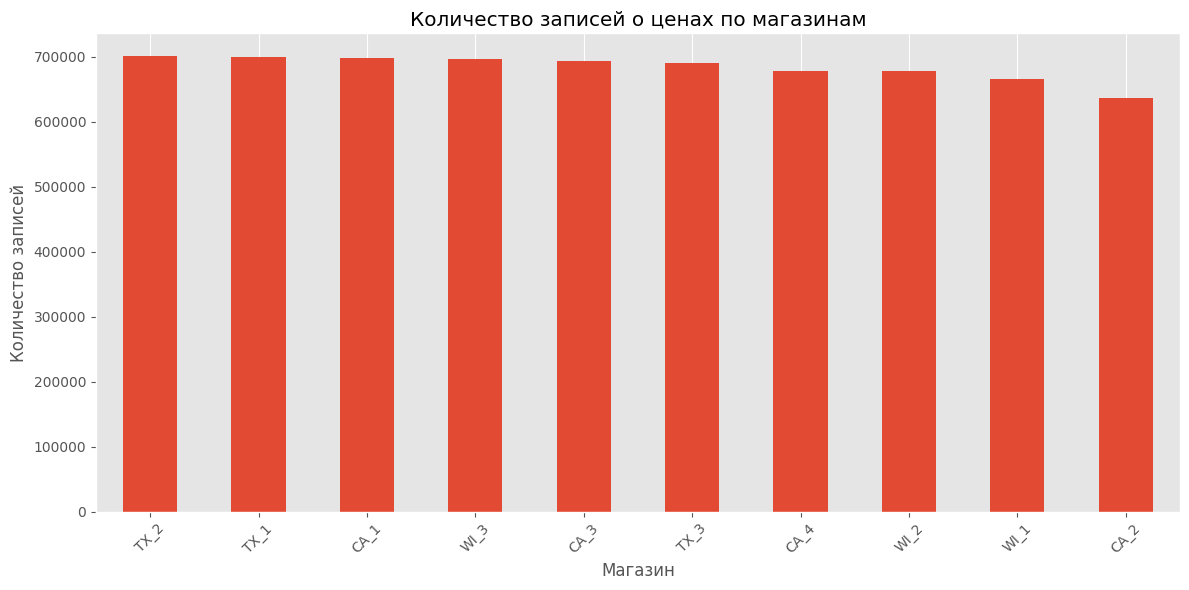

In [4]:
# Графики распределения позиций по магазинам и категориям

plt.figure(figsize=(12, 6))
sell_prices_df['store_id'].value_counts().plot(kind='bar')
plt.title('Количество записей о ценах по магазинам')
plt.xlabel('Магазин')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

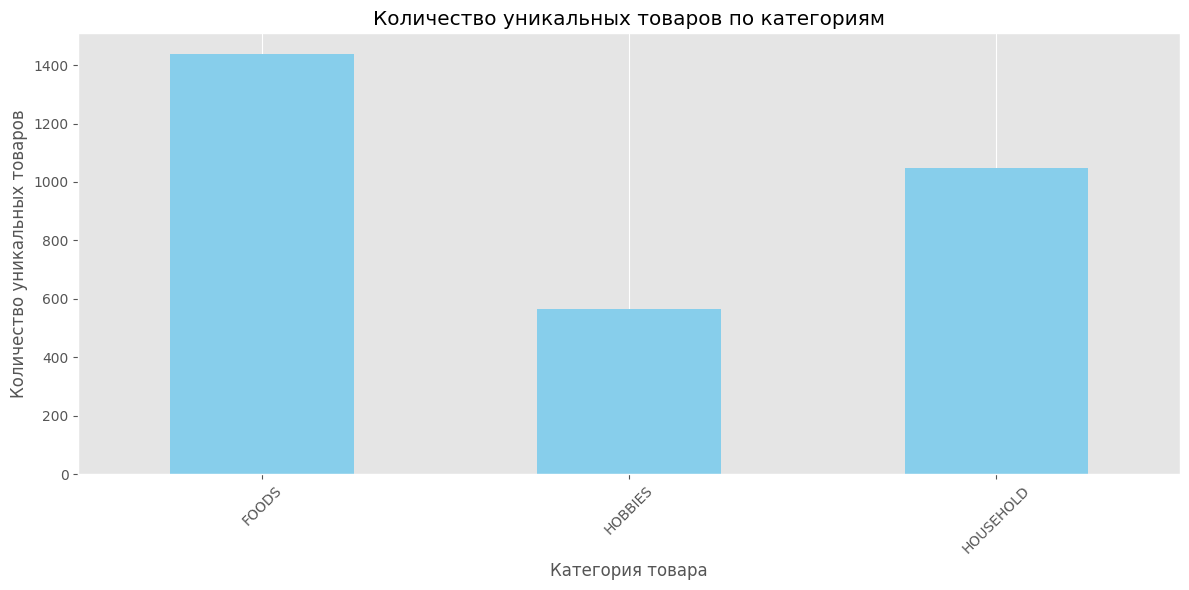

In [5]:
plt.figure(figsize=(12, 6))
items_per_category = sales_train_validation_df.groupby('cat_id', observed=True)['item_id'].nunique()
items_per_category.plot(kind='bar', color='skyblue')
plt.title('Количество уникальных товаров по категориям')
plt.xlabel('Категория товара')
plt.ylabel('Количество уникальных товаров')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Выводы распределения данных по магазинам и категориям:

### 1. Распределение записей о ценах по магазинам:
- Количество записей о ценах практически равномерно распределено по магазинам. Значимых отклонений нет.
- Это говорит о том, что данные по магазинам сбалансированы и подходят для сравнительного анализа и моделирования без дополнительной корректировки.

### 2. Количество уникальных товаров по категориям:
- Наибольшее количество уникальных товаров представлено в категории `FOODS`.
- Категория `HOUSEHOLD` также содержит значительное число уникальных позиций, в то время как категория `HOBBIES` является наименее многочисленной.
- Данное распределение подчеркивает необходимость учитывать категориальную специфику при моделировании цен.

Полученные результаты полезны для создания новых признаков, связанных с магазинами и категориями товаров.


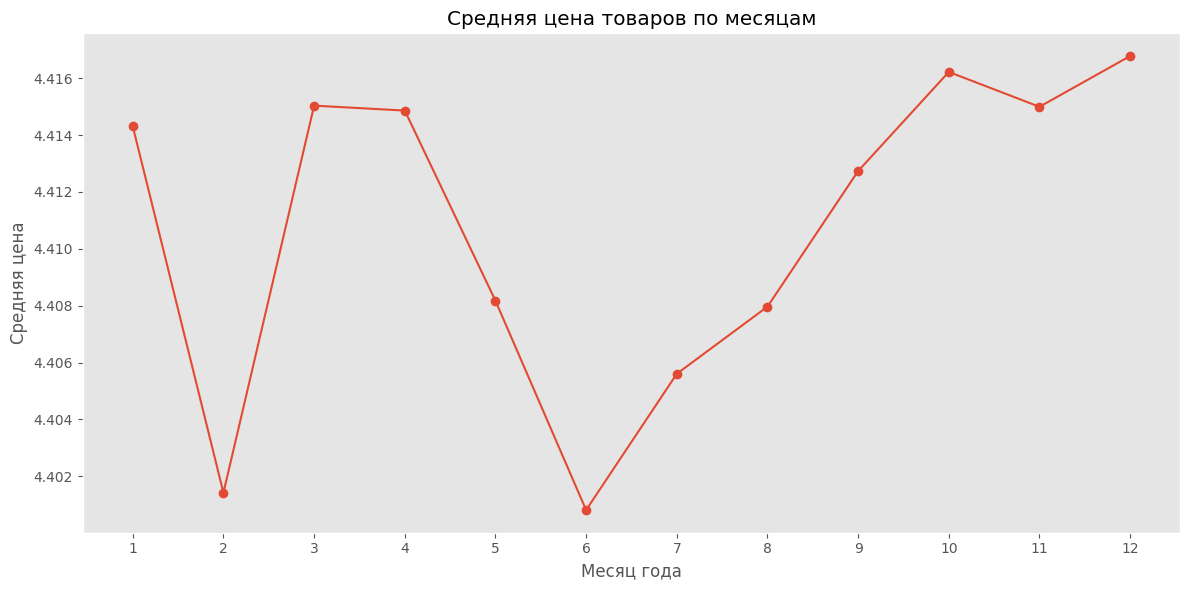

In [6]:
# Сезонный и временной анализ средних цен по месяцам и дням недели

# Соединение таблиц sell_prices и calendar
prices_calendar_df = sell_prices_df.merge(calendar_df, on='wm_yr_wk')

# Средняя цена по месяцам
monthly_prices = prices_calendar_df.groupby('month')['sell_price'].mean()

plt.figure(figsize=(12, 6))
monthly_prices.plot(marker='o')
plt.title('Средняя цена товаров по месяцам')
plt.xlabel('Месяц года')
plt.ylabel('Средняя цена')
plt.grid()
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

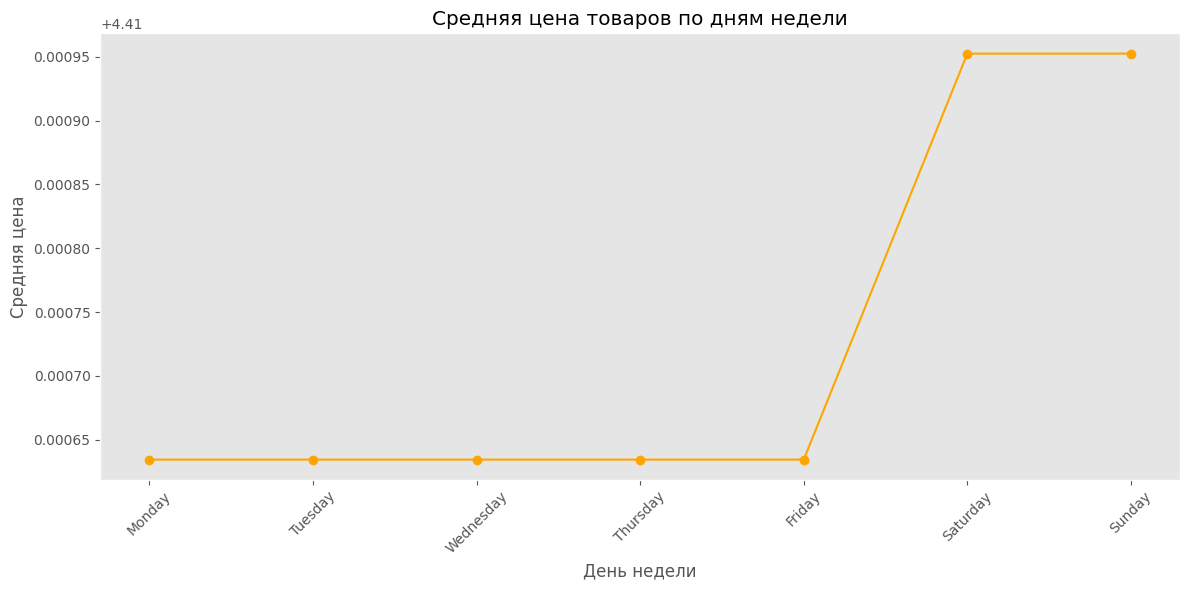

In [7]:
# Средняя цена по дням недели
weekday_prices = prices_calendar_df.groupby('weekday')['sell_price'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 6))
weekday_prices.plot(marker='o', color='orange')
plt.title('Средняя цена товаров по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя цена')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Выводы по сезонному и временному анализу средних цен

### 1. Средняя цена по месяцам:
- Средняя цена товаров незначительно варьируется в течение года, наблюдаются сезонные колебания.
- Минимальная средняя цена наблюдается в феврале и июне, максимальная — в конце года. Это может быть связано с сезонными акциями и распродажами.

### 2. Средняя цена по дням недели:
- Цены стабильно низкие в будние дни и резко возрастают на выходные (суббота и воскресенье). Хотя разница очень небольшая, это может свидетельствовать о влиянии потребительского спроса и стратегий ценообразования магазинов.

Полученные результаты показывают наличие сезонных и недельных паттернов, которые полезно учитывать при создании признаков и построении прогнозных моделей.


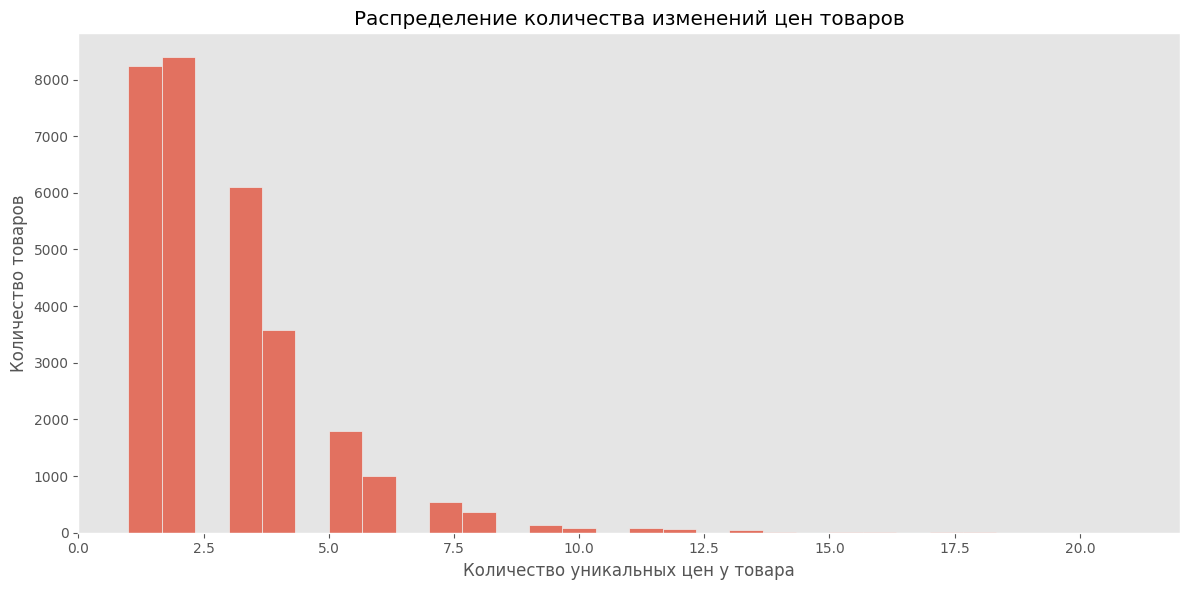

Процент товаров, которые меняли цену более одного раза: 72.95%


In [8]:
# Анализ динамики изменения цен товаров во времени

# Рассчитаем количество изменений цены для каждого товара в каждом магазине
price_changes = sell_prices_df.groupby(['store_id', 'item_id'], observed=True)['sell_price'].nunique().reset_index()
price_changes.columns = ['store_id', 'item_id', 'price_change_count']

# Визуализация распределения количества изменений цен
plt.figure(figsize=(12, 6))
sns.histplot(price_changes['price_change_count'], bins=30, kde=False)
plt.title('Распределение количества изменений цен товаров')
plt.xlabel('Количество уникальных цен у товара')
plt.ylabel('Количество товаров')
plt.grid()
plt.tight_layout()
plt.show()

# Процент товаров с изменением цены более 1 раза
multiple_price_changes = (price_changes['price_change_count'] > 1).mean() * 100
print(f'Процент товаров, которые меняли цену более одного раза: {multiple_price_changes:.2f}%')

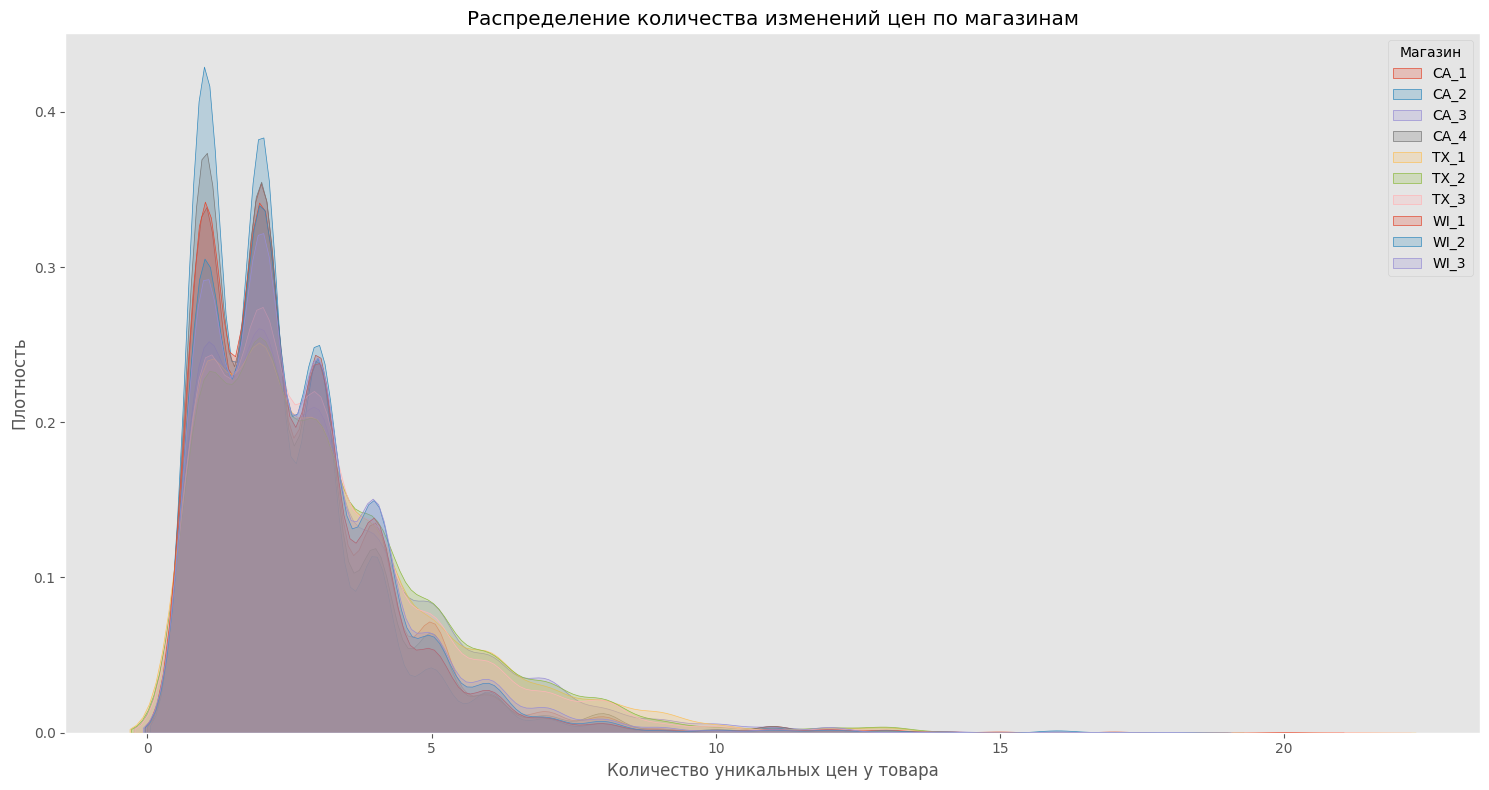

In [9]:
# Анализ количества изменений цен в разбивке по магазинам

plt.figure(figsize=(15, 8))
for store in price_changes['store_id'].unique():
    sns.kdeplot(
        price_changes[price_changes['store_id'] == store]['price_change_count'],
        label=store,
        fill=True
    )

plt.title('Распределение количества изменений цен по магазинам')
plt.xlabel('Количество уникальных цен у товара')
plt.ylabel('Плотность')
plt.legend(title='Магазин')
plt.grid()
plt.tight_layout()
plt.show()

## Выводы по анализу динамики изменения цен товаров

### 1. Общее распределение количества изменений цен:
- Большинство товаров изменяют цену от 1 до 3 раз за весь период наблюдений.
- Товары, меняющие цену более 5 раз, встречаются относительно редко, но присутствуют в данных.
- Подавляющее большинство товаров имеют стабильные или редко изменяющиеся цены.

### 2. Распределение изменений цен по магазинам:
- Распределения количества изменений цен по магазинам в целом похожи и демонстрируют общую тенденцию к стабильности цен.
- Некоторые магазины проявляют чуть большую активность в изменении цен, но различия минимальны.

**Итог:**  
Выявлено, что большинство товаров характеризуется стабильной ценой. Тем не менее, для части товаров наблюдаются регулярные изменения цен, которые стоит учитывать при построении модели прогнозирования.

Эти результаты подтверждают целесообразность создания признаков, связанных с динамикой изменения цены.



In [10]:
# Общая статистика цен
print("Общая статистика цен:")
display(sell_prices_df['sell_price'].describe())

Общая статистика цен:


,sell_price
count,6841121.00
mean,4.41
std,3.41
min,0.01
25%,2.18
50%,3.47
75%,5.84
max,107.32


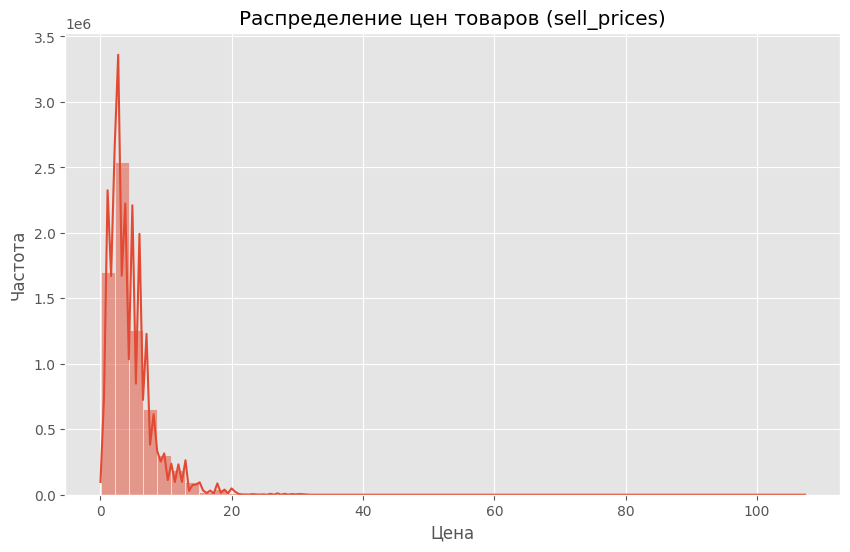

In [11]:
# Распределение цен (гистограмма)
plt.figure(figsize=(10, 6))
sns.histplot(sell_prices_df['sell_price'], bins=50, kde=True)
plt.title('Распределение цен товаров (sell_prices)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

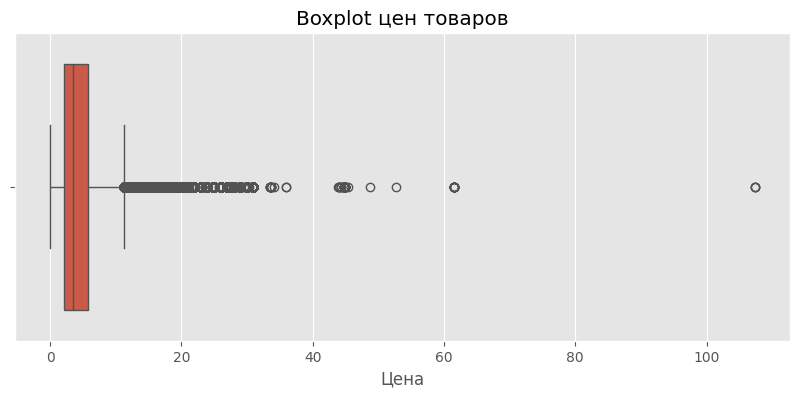

In [12]:
# Проверим наличие выбросов
plt.figure(figsize=(10, 4))
sns.boxplot(x=sell_prices_df['sell_price'])
plt.title('Boxplot цен товаров')
plt.xlabel('Цена')
plt.show()

## Выводы по шагу анализа общего распределения цен товаров:

### 1. Распределение цен товаров:
- Распределение цен сильно смещено вправо, большинство товаров имеют цену в диапазоне от 1 до 10 единиц.
- Небольшое количество товаров имеет значительно более высокие цены (более 40), что может свидетельствовать о товарах с особыми характеристиками или премиум-категории.

### 2. Анализ выбросов (Boxplot):
- Подтверждается наличие значительного количества выбросов — товаров с очень высокой ценой, которые явно отличаются от основной массы.
- Такие выбросы необходимо учитывать при создании прогнозных моделей, так как они могут существенно влиять на результат.

Эти особенности следует учесть при дальнейших этапах обработки данных и моделирования.



In [13]:
# Анализ количества событий и их типов
print("Количество уникальных событий event_name_1:", calendar_df['event_name_1'].nunique())
print("Количество уникальных событий event_type_1:", calendar_df['event_type_1'].nunique())
print("Количество уникальных событий event_name_2:", calendar_df['event_name_2'].nunique())
print("Количество уникальных событий event_type_2:", calendar_df['event_type_2'].nunique())

Количество уникальных событий event_name_1: 31
Количество уникальных событий event_type_1: 5
Количество уникальных событий event_name_2: 5
Количество уникальных событий event_type_2: 3


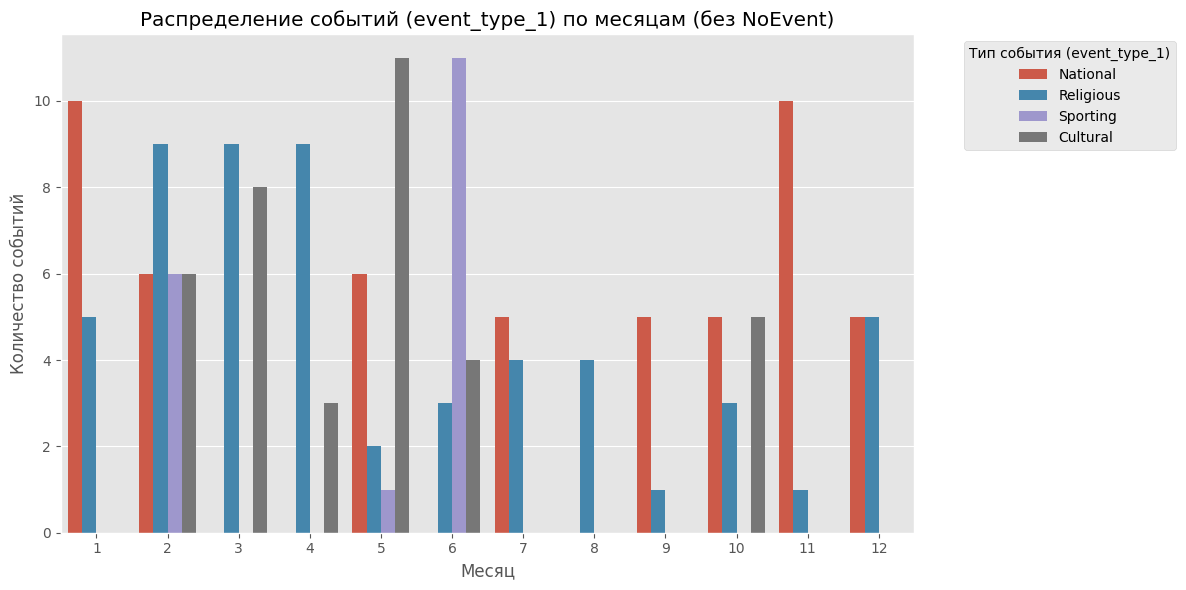

In [14]:
# График распределения событий event_type_1 по месяцам года
events_only_df = calendar_df[calendar_df['event_type_1'] != 'NoEvent']

plt.figure(figsize=(12, 6))
sns.countplot(data=events_only_df, x=events_only_df['date'].dt.month, hue='event_type_1')
plt.title('Распределение событий (event_type_1) по месяцам (без NoEvent)')
plt.xlabel('Месяц')
plt.ylabel('Количество событий')
plt.legend(title='Тип события (event_type_1)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

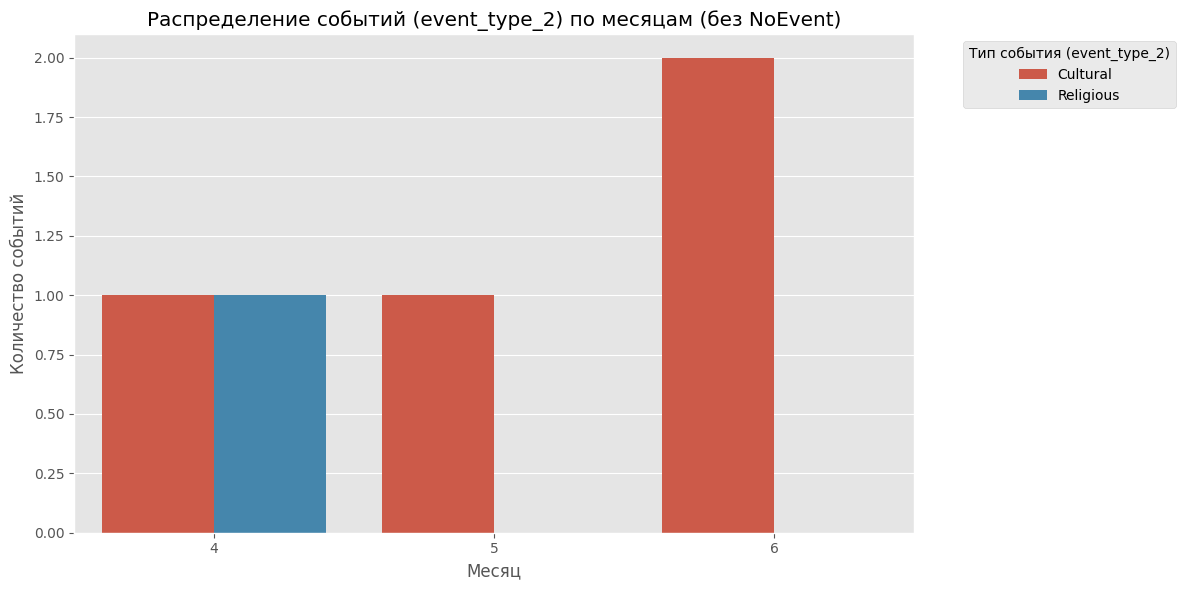

In [15]:
# График распределения событий event_type_2 по месяцам года (без NoEvent)
events_type_2_df = calendar_df[calendar_df['event_type_2'] != 'NoEvent']

plt.figure(figsize=(12, 6))
sns.countplot(data=events_type_2_df, x=events_type_2_df['date'].dt.month, hue='event_type_2')
plt.title('Распределение событий (event_type_2) по месяцам (без NoEvent)')
plt.xlabel('Месяц')
plt.ylabel('Количество событий')
plt.legend(title='Тип события (event_type_2)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

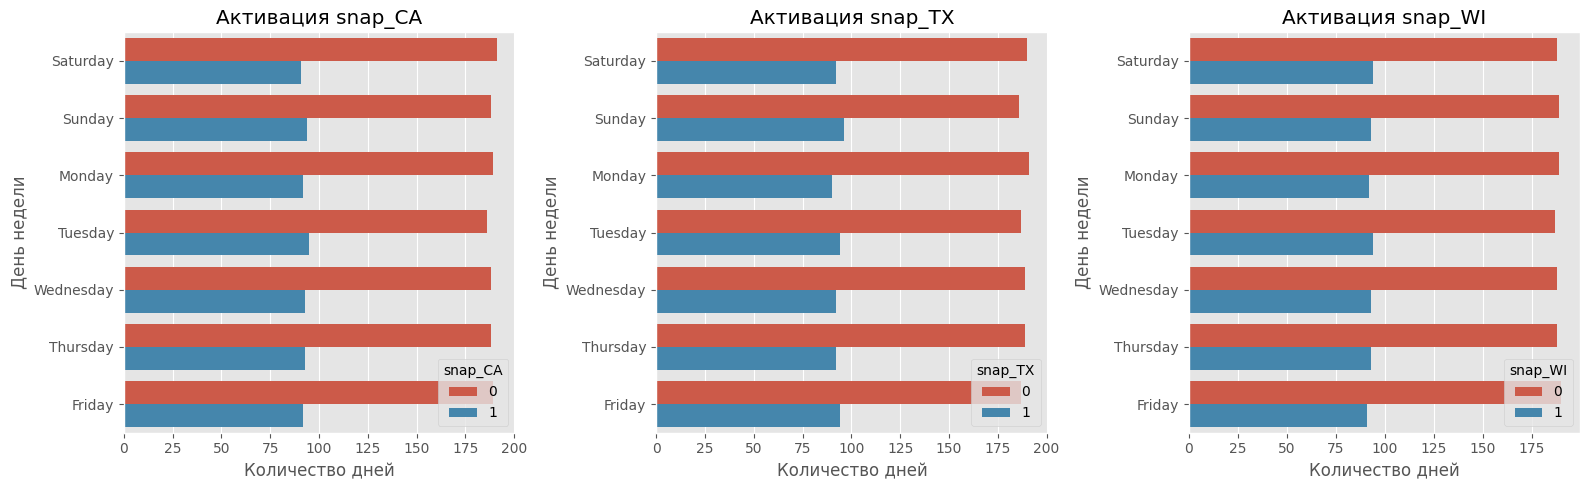

In [16]:
# Анализ активации SNAP по дням недели
snap_cols = ['snap_CA', 'snap_TX', 'snap_WI']

plt.figure(figsize=(16, 5))
for i, snap_col in enumerate(snap_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=calendar_df, y=calendar_df['date'].dt.day_name(), hue=snap_col)
    plt.title(f'Активация {snap_col}')
    plt.xlabel('Количество дней')
    plt.ylabel('День недели')
plt.tight_layout()
plt.show()

## Выводы по шагу анализа событий и активации программы SNAP:

### 1. Анализ уникальных событий:
- Всего в данных представлено 31 уникальное событие типа `event_name_1` и 5 уникальных типов (`event_type_1`).
- Вторичные события (`event_type_2`) встречаются редко: всего 5 уникальных событий с 3 типами.

### 2. Распределение событий `event_type_1` по месяцам:
- Наблюдается равномерное распределение различных типов событий по месяцам, однако ярко выражена сезонность некоторых категорий (например, религиозные и национальные события чаще встречаются в начале и конце года).

### 3. Распределение событий `event_type_2` по месяцам:
- События этого типа крайне редки и происходят только в период с апреля по июнь.
- Стоит дополнительно изучить их влияние, но из-за редкости событий, значительное влияние на модель маловероятно.

### 4. Активность программы SNAP:
- Программа SNAP активируется регулярно, но её дни активации различаются по штатам.
- Максимальная активность наблюдается в начале и середине недели. Важно учесть этот признак в прогнозных моделях, так как он может влиять на изменение цен и спроса.

Эти наблюдения необходимо использовать при генерации признаков в следующем этапе обработки данных.

In [17]:
# Вычислим суммарные продажи по дням (агрегация по всем товарам)
sales_columns_validation = [col for col in sales_train_validation_df.columns if col.startswith('d_')]
daily_sales_validation = sales_train_validation_df[sales_columns_validation].sum(axis=0)

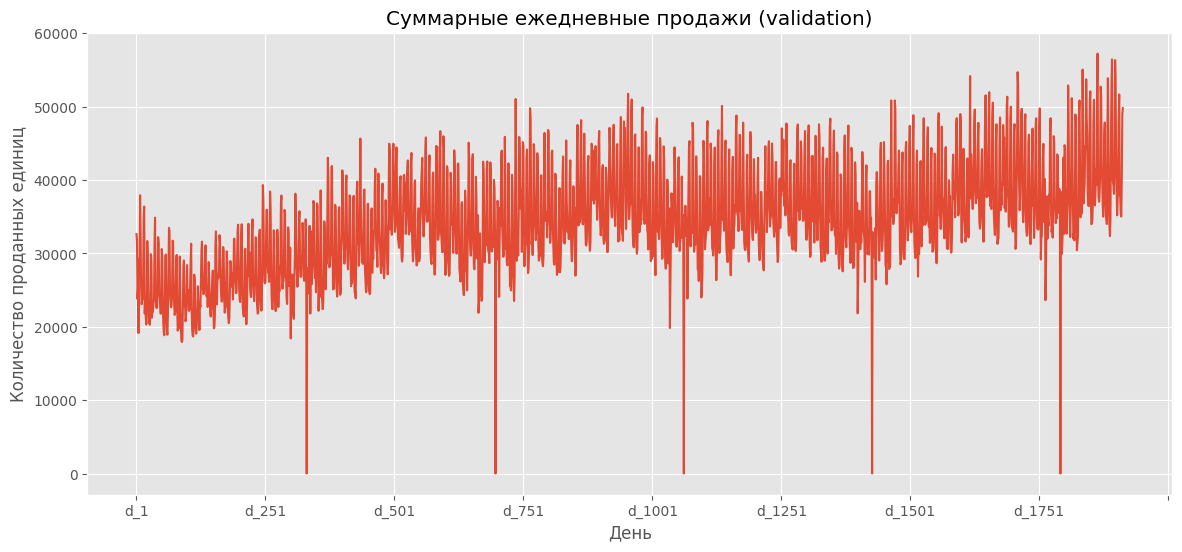

In [18]:
# Визуализация общей динамики продаж во времени
plt.figure(figsize=(14, 6))
daily_sales_validation.plot()
plt.title('Суммарные ежедневные продажи (validation)')
plt.xlabel('День')
plt.ylabel('Количество проданных единиц')
plt.grid(True)
plt.show()

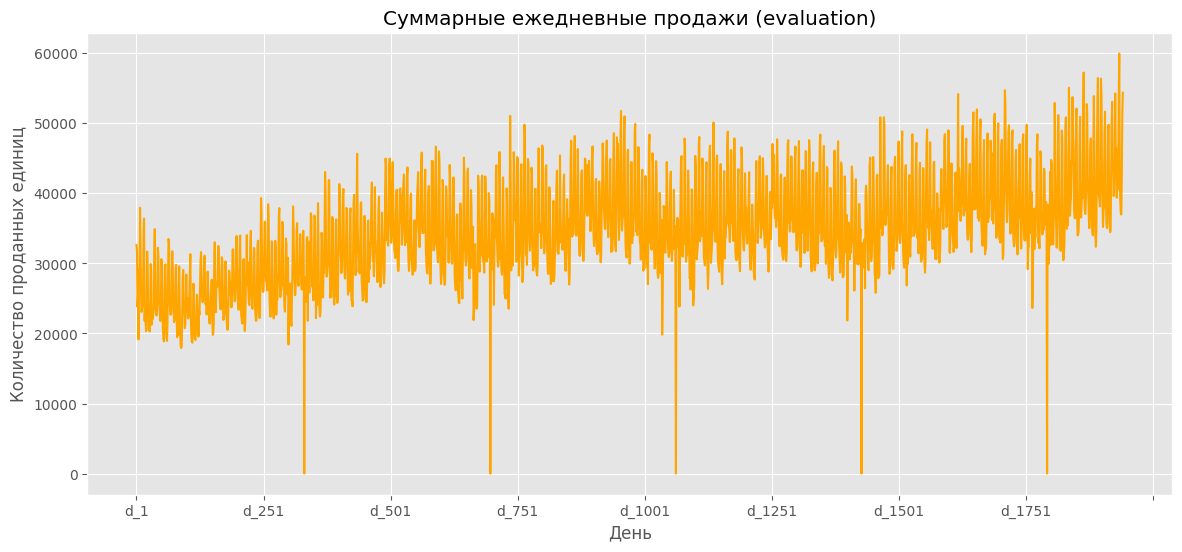

In [19]:
# Аналогично для evaluation (для сравнения)
sales_columns_evaluation = [col for col in sales_train_evaluation_df.columns if col.startswith('d_')]
daily_sales_evaluation = sales_train_evaluation_df[sales_columns_evaluation].sum(axis=0)

plt.figure(figsize=(14, 6))
daily_sales_evaluation.plot(color='orange')
plt.title('Суммарные ежедневные продажи (evaluation)')
plt.xlabel('День')
plt.ylabel('Количество проданных единиц')
plt.grid(True)
plt.show()

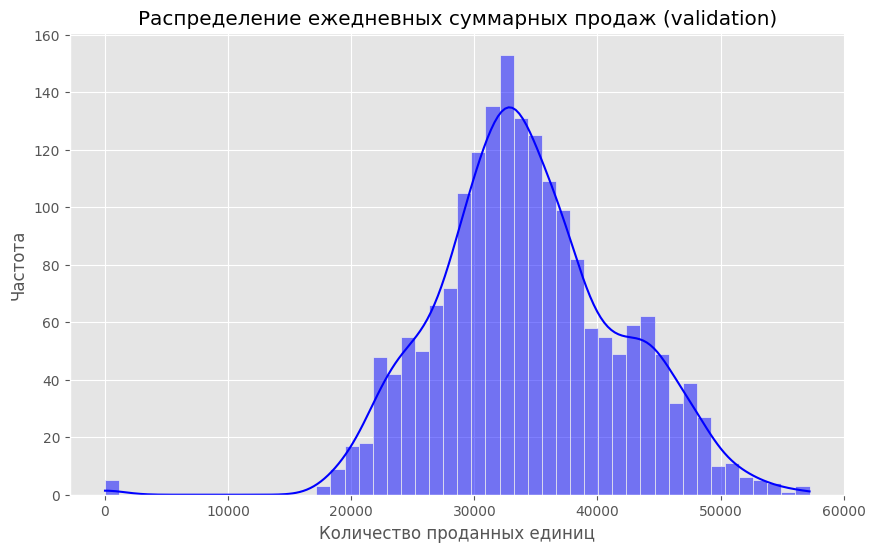

In [20]:
# Анализ распределения ежедневных продаж (validation)
plt.figure(figsize=(10, 6))
sns.histplot(daily_sales_validation, bins=50, kde=True, color='blue')
plt.title('Распределение ежедневных суммарных продаж (validation)')
plt.xlabel('Количество проданных единиц')
plt.ylabel('Частота')
plt.show()

## Выводы по шагу анализа общей динамики и распределения ежедневных продаж:

### 1. Общая динамика суммарных продаж:
- На графиках временных рядов суммарных ежедневных продаж (`validation` и `evaluation`) отчётливо заметен стабильный восходящий тренд.
- В данных явно присутствуют резкие кратковременные падения продаж, возможно связанные с определёнными событиями или проблемами в сборе данных. Это стоит дополнительно исследовать.

### 2. Распределение ежедневных суммарных продаж:
- Распределение ежедневных суммарных продаж близко к нормальному, с небольшим смещением вправо.
- Средние продажи находятся примерно в диапазоне 30-35 тысяч единиц в день, хотя присутствуют дни с экстремально низкими продажами (выбросы).

Эти наблюдения подчёркивают важность учёта трендов и аномалий при прогнозировании цен и анализе спроса.


## Итоговые выводы по ноутбуку 02_eda_and_feature_analysis:

В результате проведённого анализа выявлены следующие ключевые закономерности и особенности данных:

1. **Цены и их распределения**:
   - Цены на товары распределены неравномерно, большинство товаров имеют цену от 1 до 10 условных единиц.
   - Имеются высокоценовые выбросы, которые необходимо учитывать при моделировании.

2. **Распределение по магазинам и категориям**:
   - Данные о ценах равномерно представлены по магазинам, что говорит о сбалансированности датасета.
   - Наибольшее количество уникальных товаров находится в категории `FOODS`, наименьшее — в категории `HOBBIES`.

3. **Сезонность и временные тренды**:
   - Наблюдаются сезонные изменения средней цены товаров (минимумы в феврале и июне, максимумы в конце года).
   - Цены товаров немного выше в выходные дни, что связано с повышением потребительского спроса.

4. **Динамика изменения цен**:
   - Большинство товаров имеют стабильную цену и меняют её редко (1–3 раза за период наблюдения).
   - Лишь небольшая часть товаров меняет цену часто, что требует отдельного внимания при генерации признаков.

5. **Календарные события и SNAP-программа**:
   - События типа `event_type_1` равномерно распределены по месяцам, однако выражена сезонность некоторых категорий событий.
   - События типа `event_type_2` крайне редки и появляются в ограниченный период (апрель–июнь).
   - Программа SNAP имеет регулярные дни активации с разным распределением по штатам и дням недели, что может повлиять на потребительскую активность и цены.

Полученные выводы и идеи признаков будут использованы в следующем ноутбуке для детальной генерации и подготовки финального датасета для моделирования.
